In [1]:
import os
import sys
import torch
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.nn as nn

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))

from model.CNN_model import CNNTextClassifier
from model.BiLSTM_model import BiLSTMModel
from language_model import train, evaluate
from evaluation import class_accuracy, class_f1_score,\
    class_wise_precision_recall, plot_confusion_matrix
from utils import tokenize, remove_stopwords, stemming, fit_tokenizer, plot_loss_acc,\
    pad_sequence, PandasDataset, get_batched_data, get_class_weights, grid_search

# Data Preparation

In [2]:
data = pd.read_csv("../data/text.csv").drop(columns="Unnamed: 0")
data.sample(10)

,text,label
169570,i feel drained trying to get around to every s...,0
125895,i feel like i know other people are also unhap...,0
97631,i am partially feeling amazed by how fast time...,5
126571,im just feeling really weepy today and my mood...,0
143016,ive been thinking it is the first time i reall...,1
85022,i have not been feeling all that fab with this...,1
331781,i feel mentally anguished and stressed a lot,0
207167,i feel that i am trying to prove myself to peo...,2
223562,cant describe any disgust situation,3
69929,i feel like i was being generous,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [4]:
# data.duplicated().sum()
data.drop_duplicates(inplace= True)

### Tokenize, stem and remove stopwords 

In [5]:
data['tokens_stemm'] = data['text'].apply(tokenize).apply(remove_stopwords).apply(stemming)
# data['tokens_stemm'] = data['tokens']
data = data[~(data['tokens_stemm'].apply(len) == 0)]
data.sample(10)

,text,label,tokens_stemm
94438,i feel supportive to all of them because i can...,2,"[feel, support, tell, inde, horribl, feel, tra..."
177120,i feel relieved that my child will be getting ...,1,"[feel, reliev, child, get, educ, next, year, d..."
278094,i feel listless broken uninterested unmotivate...,0,"[feel, listless, broken, uninterest, unmotiv, ..."
129030,i feel tortured with no soul like im breathing...,4,"[feel, tortur, soul, like, im, breath, air]"
174341,i bought a christmas present for my girlfriend...,1,"[bought, christma, present, girlfriend, way, h..."
312213,i know i m supposed to practice faithfulness t...,3,"[know, suppos, practic, faith, moment, feel, i..."
90517,i love receiving the awards and feel truly hon...,1,"[love, receiv, award, feel, truli, honour, don..."
55660,i was not feeling very festive but rather feel...,1,"[feel, festiv, rather, feel, like, need, alon,..."
2526,i feel a bit insulted,3,"[feel, bit, insult]"
214103,i may feel rotten this morning i am also a pro...,0,"[may, feel, rotten, morn, also, profession, li..."


### Split data into train and test sets. Calculate class weights.

In [6]:
# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(data['tokens_stemm'], data['label'], test_size=0.2, random_state=42)
# Calculate class weights
class_weights = get_class_weights(data['label'])
print(f"Class Weights : {class_weights}")

train_data = pd.concat((x_train,y_train), axis=1).reset_index()
test_data = pd.concat((x_test,y_test), axis=1).reset_index()
print(f"Train size: {len(train_data)}\tTest size: {len(test_data)}")

Class Weights : tensor([0.5732, 0.4926, 2.0104, 1.2118, 1.4551, 4.6361])
Train size: 332886	Test size: 83222


### Fit tokenizer

In [7]:
# tokenizer = fit_tokenizer(data['tokens_stemm'])
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print("Tokenizer saved to file.")
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Pad the sequences to have uniform length. Batch the data for training.

In [8]:
train_data['padded'] = train_data['tokens_stemm'].apply(pad_sequence, tokenizer= tokenizer)
test_data['padded'] = test_data['tokens_stemm'].apply(pad_sequence, tokenizer= tokenizer)
print("Data prepared for model!")
train_dataset = PandasDataset(train_data)
test_dataset = PandasDataset(test_data)
train_batched = get_batched_data(train_dataset, batch_size= 256)
test_batched = get_batched_data(test_dataset, batch_size= 64)

Data prepared for model!


# CNN

### Initialise the model

In [14]:
model = CNNTextClassifier()
print(model)

CNNTextClassifier(
  (embedding): Embedding(52000, 32)
  (conv): Sequential(
    (0): Conv1d(32, 24, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=98, stride=98, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (dense): Sequential(
    (0): Linear(in_features=24, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=6, bias=True)
  )
)


In [15]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters: 1666830


### Train the model

In [11]:
# parameter_configs = {
#     'embedding_dim': [32],
#     'num_filters': [24],
#     'kernel_size': [3],
#     'hidden_units': [16], 
#     }
# parameter_configurations = grid_search(parameter_configs)

In [16]:
model, losses, accs = train(model, train_batched, num_epochs= 6,
                            lr= 0.005, lr_floor= 0.0001,
                            class_weights= class_weights)
    # conf_mat = evaluate(model, test_batched)
    # accuracies = class_accuracy(conf_mat)
    # f1_scores = class_f1_score(conf_mat)

    # average_accuracy = np.mean(accuracies)
    # average_f1 = np.mean(f1_scores)
    # print(params)
    # print(f"Average acccuracy: {average_accuracy*100:.2f}%")
    # print(f"Average F1: {average_f1*100:.2f}%")

  0%|          | 0/1041 [00:00<?, ?it/s]

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.005
    lr: 0.005
    maximize: False
    weight_decay: 0
)


  0%|          | 1/1041 [00:00<01:54,  9.06it/s]

Epoch 1/6, Iter 1/4 Train Loss: 0.4484, Train Accuracy: 79.325%, Val Accuracy: 90.159%


  0%|          | 1/1041 [00:00<02:00,  8.60it/s]

Epoch 1/6, Iter 2/4 Train Loss: 0.3213, Train Accuracy: 84.964%, Val Accuracy: 91.177%


  0%|          | 1/1041 [00:00<02:13,  7.78it/s]

Epoch 1/6, Iter 3/4 Train Loss: 0.2754, Train Accuracy: 86.971%, Val Accuracy: 90.974%


  0%|          | 1/1041 [00:00<02:12,  7.87it/s]

Epoch 1/6, Iter 4/4 Train Loss: 0.2500, Train Accuracy: 88.053%, Val Accuracy: 91.725%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 1/6, Iter 5/4 Train Loss: 0.2335, Train Accuracy: 88.759%, Val Accuracy: 91.644%


  0%|          | 1/1041 [00:00<03:09,  5.48it/s]

Epoch 2/6, Iter 1/4 Train Loss: 0.1602, Train Accuracy: 91.835%, Val Accuracy: 91.668%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 2/6, Iter 2/4 Train Loss: 0.1575, Train Accuracy: 91.930%, Val Accuracy: 92.192%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 2/6, Iter 3/4 Train Loss: 0.1548, Train Accuracy: 92.031%, Val Accuracy: 92.176%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 2/6, Iter 4/4 Train Loss: 0.1521, Train Accuracy: 92.132%, Val Accuracy: 92.499%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 2/6, Iter 5/4 Train Loss: 0.1499, Train Accuracy: 92.214%, Val Accuracy: 92.960%


  0%|          | 1/1041 [00:00<02:41,  6.43it/s]

Epoch 3/6, Iter 1/4 Train Loss: 0.1352, Train Accuracy: 92.837%, Val Accuracy: 92.893%


  0%|          | 1/1041 [00:00<02:28,  7.02it/s]

Epoch 3/6, Iter 2/4 Train Loss: 0.1338, Train Accuracy: 92.921%, Val Accuracy: 92.960%


  0%|          | 1/1041 [00:00<02:40,  6.48it/s]

Epoch 3/6, Iter 3/4 Train Loss: 0.1323, Train Accuracy: 92.984%, Val Accuracy: 92.885%


  0%|          | 1/1041 [00:00<03:06,  5.57it/s]

Epoch 3/6, Iter 4/4 Train Loss: 0.1307, Train Accuracy: 93.035%, Val Accuracy: 93.281%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 3/6, Iter 5/4 Train Loss: 0.1292, Train Accuracy: 93.096%, Val Accuracy: 93.579%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 4/6, Iter 1/4 Train Loss: 0.1186, Train Accuracy: 93.518%, Val Accuracy: 93.468%


  0%|          | 1/1041 [00:00<02:14,  7.74it/s]

Epoch 4/6, Iter 2/4 Train Loss: 0.1180, Train Accuracy: 93.541%, Val Accuracy: 93.622%


  0%|          | 1/1041 [00:00<03:03,  5.68it/s]

Epoch 4/6, Iter 3/4 Train Loss: 0.1169, Train Accuracy: 93.602%, Val Accuracy: 93.636%


  0%|          | 1/1041 [00:00<02:18,  7.51it/s]

Epoch 4/6, Iter 4/4 Train Loss: 0.1158, Train Accuracy: 93.646%, Val Accuracy: 93.858%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 4/6, Iter 5/4 Train Loss: 0.1146, Train Accuracy: 93.697%, Val Accuracy: 93.864%


  0%|          | 1/1041 [00:00<02:18,  7.51it/s]

Epoch 5/6, Iter 1/4 Train Loss: 0.1072, Train Accuracy: 94.002%, Val Accuracy: 93.957%


  0%|          | 1/1041 [00:00<02:34,  6.75it/s]

Epoch 5/6, Iter 2/4 Train Loss: 0.1066, Train Accuracy: 94.040%, Val Accuracy: 93.894%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 5/6, Iter 3/4 Train Loss: 0.1061, Train Accuracy: 94.059%, Val Accuracy: 94.228%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 5/6, Iter 4/4 Train Loss: 0.1055, Train Accuracy: 94.085%, Val Accuracy: 94.193%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 5/6, Iter 5/4 Train Loss: 0.1049, Train Accuracy: 94.110%, Val Accuracy: 94.189%


  0%|          | 1/1041 [00:00<02:38,  6.55it/s]

Epoch 6/6, Iter 1/4 Train Loss: 0.1012, Train Accuracy: 94.238%, Val Accuracy: 94.349%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 6/6, Iter 2/4 Train Loss: 0.1006, Train Accuracy: 94.281%, Val Accuracy: 94.123%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 6/6, Iter 3/4 Train Loss: 0.1002, Train Accuracy: 94.294%, Val Accuracy: 94.334%


  0%|          | 1/1041 [00:00<02:10,  7.96it/s]

Epoch 6/6, Iter 4/4 Train Loss: 0.0999, Train Accuracy: 94.300%, Val Accuracy: 94.415%


100%|██████████| 1041/1041 [02:52<00:00,  6.03it/s]


Epoch 6/6, Iter 5/4 Train Loss: 0.0997, Train Accuracy: 94.308%, Val Accuracy: 94.423%


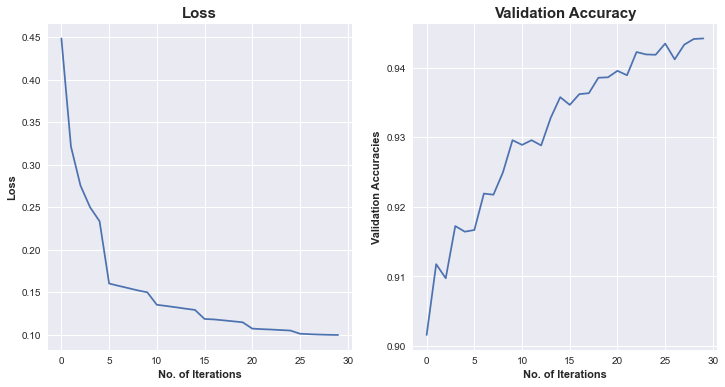

In [17]:
# plot_loss_acc(loss= losses, accs= accs, modelname= 'cnn', plot= False)
plot_loss_acc(loss= losses, accs= accs, modelname= 'cnn', plot= True)

  0%|          | 4/1301 [00:00<00:41, 31.50it/s]

-----------------------------------Evaluating model on test data------------------------------------


100%|██████████| 1301/1301 [00:25<00:00, 50.68it/s]


Average acccuracy: 84.43%
Average F1: 86.40%


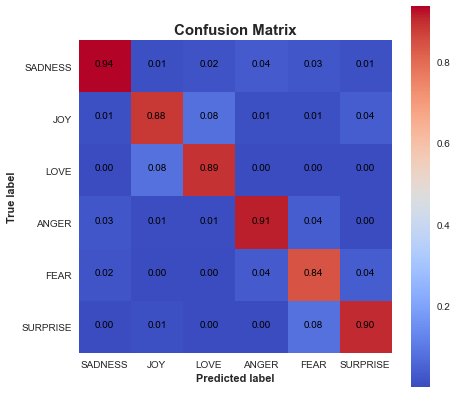

In [18]:
conf_mat = evaluate(model, test_batched)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'cnn', plot= True)

In [19]:
accuracies = class_accuracy(conf_mat)
f1_scores = class_f1_score(conf_mat)
precisions, recalls = class_wise_precision_recall(conf_mat)

average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print(f"Average acccuracy: {average_accuracy*100:.2f}%")
print(f"Average F1: {average_f1*100:.2f}%")

output_df = pd.DataFrame({"Emotion":['Sadness','Joy','Love','Anger','Fear','Surprise'],
                            'Accuracy':accuracies, 'F1_Score':f1_scores,
                            'Precision':precisions, 'Recall':recalls})
output_df

Average acccuracy: 84.43%
Average F1: 86.40%


,Emotion,Accuracy,F1_Score,Precision,Recall
0,Sadness,0.952903,0.944034,0.935329,0.952903
1,Joy,0.955544,0.917286,0.881973,0.955544
2,Love,0.699131,0.782451,0.888317,0.699131
3,Anger,0.894235,0.902924,0.911783,0.894235
4,Fear,0.870831,0.854129,0.838055,0.870831
5,Surprise,0.693390,0.783362,0.900163,0.693390


In [20]:
torch.save(model, f= "../model/cnn.pth")

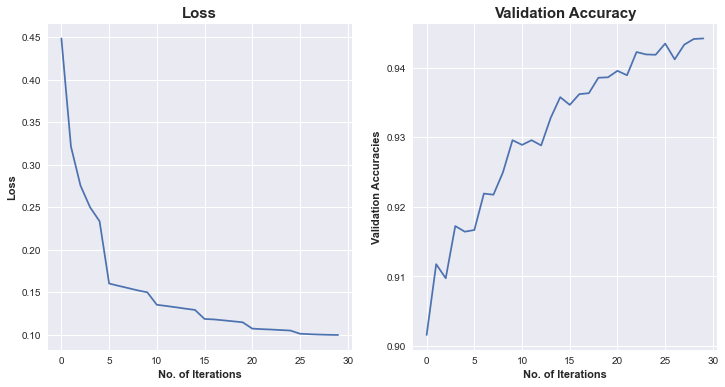

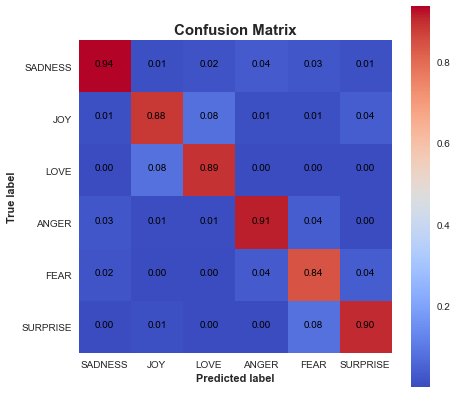

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, AnyStr
from itertools import product

def plot_loss_acc(loss: List, accs: List, modelname: AnyStr, plot = False) -> None:
    plt.style.use("seaborn")
    fig, axes = plt.subplots(1,2, figsize= (12,6))
    num_of_items = len(loss)
    sns.lineplot(ax= axes[0], x= range(num_of_items), y= loss)
    sns.lineplot(ax= axes[1], x= range(num_of_items), y= accs)
    
    axes[0].set_xlabel("No. of Iterations", fontdict={"fontweight":"bold"})
    axes[1].set_xlabel("No. of Iterations", fontdict={"fontweight":"bold"})
    axes[0].set_ylabel("Loss", fontdict={"fontweight":"bold"})
    axes[1].set_ylabel("Validation Accuracies", fontdict={"fontweight":"bold"})
    axes[0].set_title("Loss", fontdict={"fontweight":"bold", "fontsize":15})
    axes[1].set_title("Validation Accuracy", fontdict={"fontweight":"bold", "fontsize":15})
    if plot:
        plt.show()
    else:
        if modelname == 'bilstm':
            fig.savefig(fname= "../images/bilstm_loss_acc.png", dpi=300)
        elif modelname == 'cnn':
            fig.savefig(fname= "../images/cnn_loss_acc.png", dpi=300)

def plot_confusion_matrix(conf_matrix, modelname, plot= False):
    labels = {0: "SADNESS", 1: "JOY", 2: "LOVE", 3: "ANGER", 4: "FEAR", 5: "SURPRISE"}
    plt.style.use("seaborn")
    plt.figure(figsize=(7,7))
    norm_conf_mat = np.divide(conf_matrix, np.sum(conf_matrix, axis= 0))
    plt.imshow(norm_conf_mat, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    
    plt.xticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    plt.yticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    
    fmt = '.2f'
    for i, j in product(range(norm_conf_mat.shape[0]), range(norm_conf_mat.shape[1])):
        plt.text(j, i, format(norm_conf_mat[i, j], fmt),
                 horizontalalignment="center",
                 color="black")
    
    plt.xlabel('Predicted label',fontdict={"fontweight":"bold"})
    plt.ylabel('True label',fontdict={"fontweight":"bold"})
    plt.title('Confusion Matrix',fontdict={"fontsize":15,"fontweight":"bold"})
    plt.grid(False)
    if plot:
        plt.show()
    else:
        if modelname == 'bilstm':
            plt.savefig(fname= "../images/bilstm_confmat.png", dpi=300)
        elif modelname == 'cnn':
            plt.savefig(fname= "../images/cnn_confmat.png", dpi=300)
            
plot_loss_acc(loss= losses, accs= accs, modelname= 'cnn', plot= False)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'cnn', plot= False)

# BiLSTM

### Initialize the model

In [22]:
model = BiLSTMModel(embedding_dim=32, hidden_size= 16, p= 0.2)
print(model)

BiLSTMModel(
  (embedding): Embedding(52000, 32)
  (lstm): LSTM(32, 16, bidirectional=True)
  (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dense): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=6, bias=True)
  )
)


In [23]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters: 1671094


### Train the model

In [24]:
model, losses, accs = train(model, train_batched, num_epochs= 6,
                            lr= 0.0005, lr_floor= 0.00005,
                            class_weights= class_weights)

  0%|          | 0/1041 [00:00<?, ?it/s]

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0005
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


  0%|          | 1/1041 [00:00<02:33,  6.78it/s]

Epoch 1/6, Iter 1/4 Train Loss: 1.5315, Train Accuracy: 27.707%, Val Accuracy: 21.820%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 1/6, Iter 2/4 Train Loss: 1.5122, Train Accuracy: 24.316%, Val Accuracy: 22.808%


  0%|          | 1/1041 [00:00<02:39,  6.54it/s]

Epoch 1/6, Iter 3/4 Train Loss: 1.4572, Train Accuracy: 24.547%, Val Accuracy: 27.699%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 1/6, Iter 4/4 Train Loss: 1.4117, Train Accuracy: 25.130%, Val Accuracy: 26.086%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 1/6, Iter 5/4 Train Loss: 1.3756, Train Accuracy: 25.622%, Val Accuracy: 36.793%


  0%|          | 1/1041 [00:00<02:50,  6.10it/s]

Epoch 2/6, Iter 1/4 Train Loss: 0.7279, Train Accuracy: 64.688%, Val Accuracy: 76.970%


  0%|          | 1/1041 [00:00<02:47,  6.19it/s]

Epoch 2/6, Iter 2/4 Train Loss: 0.8096, Train Accuracy: 62.429%, Val Accuracy: 75.930%


  0%|          | 1/1041 [00:00<02:37,  6.61it/s]

Epoch 2/6, Iter 3/4 Train Loss: 0.7324, Train Accuracy: 67.518%, Val Accuracy: 81.594%


  0%|          | 1/1041 [00:00<02:37,  6.59it/s]

Epoch 2/6, Iter 4/4 Train Loss: 0.6612, Train Accuracy: 71.438%, Val Accuracy: 84.199%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 2/6, Iter 5/4 Train Loss: 0.6087, Train Accuracy: 74.207%, Val Accuracy: 86.582%


  0%|          | 1/1041 [00:00<02:39,  6.51it/s]

Epoch 3/6, Iter 1/4 Train Loss: 0.4060, Train Accuracy: 85.065%, Val Accuracy: 86.821%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 3/6, Iter 2/4 Train Loss: 0.3601, Train Accuracy: 86.491%, Val Accuracy: 88.600%


  0%|          | 1/1041 [00:00<02:37,  6.59it/s]

Epoch 3/6, Iter 3/4 Train Loss: 0.3343, Train Accuracy: 87.244%, Val Accuracy: 89.128%


  0%|          | 1/1041 [00:00<02:25,  7.15it/s]

Epoch 3/6, Iter 4/4 Train Loss: 0.3169, Train Accuracy: 87.728%, Val Accuracy: 89.675%


  0%|          | 1/1041 [00:00<02:43,  6.35it/s]

Epoch 3/6, Iter 5/4 Train Loss: 0.3037, Train Accuracy: 88.096%, Val Accuracy: 89.818%


  0%|          | 1/1041 [00:00<02:47,  6.21it/s]

Epoch 4/6, Iter 1/4 Train Loss: 0.3011, Train Accuracy: 88.501%, Val Accuracy: 89.645%


  0%|          | 1/1041 [00:00<02:45,  6.28it/s]

Epoch 4/6, Iter 2/4 Train Loss: 0.2679, Train Accuracy: 89.265%, Val Accuracy: 90.362%


  0%|          | 1/1041 [00:00<02:53,  5.99it/s]

Epoch 4/6, Iter 3/4 Train Loss: 0.2537, Train Accuracy: 89.621%, Val Accuracy: 90.455%


  0%|          | 1/1041 [00:00<02:46,  6.24it/s]

Epoch 4/6, Iter 4/4 Train Loss: 0.2449, Train Accuracy: 89.844%, Val Accuracy: 90.582%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 4/6, Iter 5/4 Train Loss: 0.2386, Train Accuracy: 89.993%, Val Accuracy: 90.950%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 5/6, Iter 1/4 Train Loss: 0.2692, Train Accuracy: 89.467%, Val Accuracy: 90.644%


  0%|          | 1/1041 [00:00<03:05,  5.59it/s]

Epoch 5/6, Iter 2/4 Train Loss: 0.2386, Train Accuracy: 90.129%, Val Accuracy: 91.003%


  0%|          | 1/1041 [00:00<02:48,  6.17it/s]

Epoch 5/6, Iter 3/4 Train Loss: 0.2269, Train Accuracy: 90.391%, Val Accuracy: 90.775%


  0%|          | 1/1041 [00:00<02:46,  6.23it/s]

Epoch 5/6, Iter 4/4 Train Loss: 0.2207, Train Accuracy: 90.536%, Val Accuracy: 91.183%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 5/6, Iter 5/4 Train Loss: 0.2164, Train Accuracy: 90.641%, Val Accuracy: 91.090%


  0%|          | 1/1041 [00:00<03:04,  5.63it/s]

Epoch 6/6, Iter 1/4 Train Loss: 0.2573, Train Accuracy: 89.764%, Val Accuracy: 90.863%


  0%|          | 1/1041 [00:00<02:54,  5.97it/s]

Epoch 6/6, Iter 2/4 Train Loss: 0.2274, Train Accuracy: 90.439%, Val Accuracy: 91.338%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 6/6, Iter 3/4 Train Loss: 0.2168, Train Accuracy: 90.682%, Val Accuracy: 91.350%


  0%|          | 0/1041 [00:00<?, ?it/s]

Epoch 6/6, Iter 4/4 Train Loss: 0.2111, Train Accuracy: 90.809%, Val Accuracy: 91.311%


100%|██████████| 1041/1041 [02:58<00:00,  5.82it/s]


Epoch 6/6, Iter 5/4 Train Loss: 0.2073, Train Accuracy: 90.904%, Val Accuracy: 91.135%


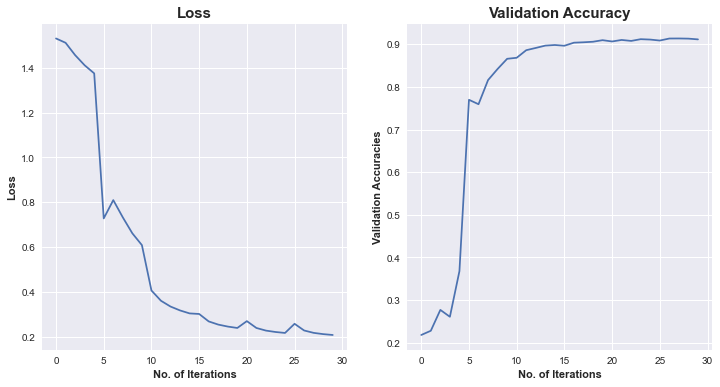

In [25]:
plot_loss_acc(loss= losses, accs= accs, modelname= 'bilstm', plot= True)

  0%|          | 1/1301 [00:00<02:33,  8.47it/s]

-----------------------------------Evaluating model on test data------------------------------------


100%|██████████| 1301/1301 [00:49<00:00, 26.35it/s]


Average acccuracy: 84.48%
Average F1: 87.04%


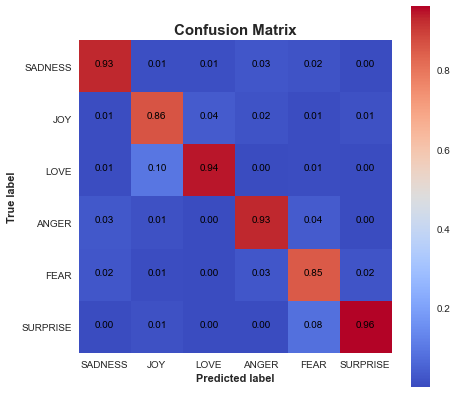

In [26]:
conf_mat = evaluate(model, test_batched)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'bilstm', plot= True)

In [27]:
accuracies = class_accuracy(conf_mat)
f1_scores = class_f1_score(conf_mat)
precisions, recalls = class_wise_precision_recall(conf_mat)

average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print(f"Average acccuracy: {average_accuracy*100:.2f}%")
print(f"Average F1: {average_f1*100:.2f}%")

output_df = pd.DataFrame({"Emotion":['Sadness','Joy','Love','Anger','Fear','Surprise'],
                            'Accuracy':accuracies, 'F1_Score':f1_scores,
                            'Precision':precisions, 'Recall':recalls})
output_df

Average acccuracy: 84.48%
Average F1: 87.04%


,Emotion,Accuracy,F1_Score,Precision,Recall
0,Sadness,0.965502,0.947051,0.929292,0.965502
1,Joy,0.972454,0.912848,0.860127,0.972454
2,Love,0.676098,0.787312,0.942319,0.676098
3,Anger,0.878934,0.902464,0.927289,0.878934
4,Fear,0.878412,0.864607,0.851228,0.878412
5,Surprise,0.697465,0.808125,0.960522,0.697465


In [28]:
torch.save(model,f= "../model/bilstm.pth")

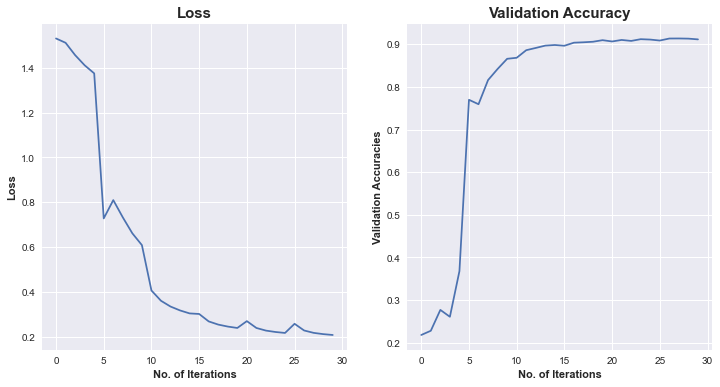

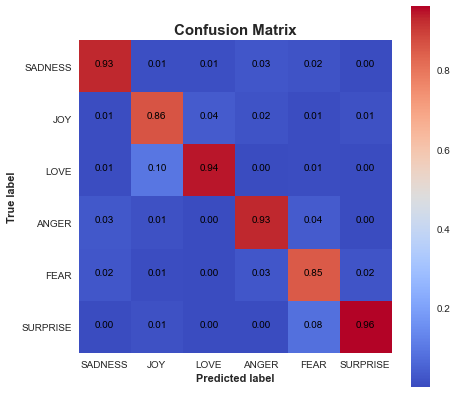

In [29]:
plot_loss_acc(loss= losses, accs= accs, modelname= 'bilstm', plot= False)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'bilstm', plot= False)

# Model Comparison

In [9]:
cnn_model = torch.load("../model/cnn.pth")
bilstm_model = torch.load("../model/bilstm.pth")
criterion = nn.CrossEntropyLoss()

In [10]:
test_batched_comparison = get_batched_data(test_dataset, batch_size= 128)
len(test_batched_comparison)

651

In [11]:
cnn_model.eval()
bilstm_model.eval()
bilstm_model.to('cpu')
cnn_loss, bilstm_loss= [], []
for batch in tqdm(test_batched_comparison):
    inputs = batch['padded']
    labels = batch['label']
    cnn_l = criterion(cnn_model(inputs), labels)
    # bilstm_l = criterion(bilstm_model(inputs), labels)

    cnn_loss.append(cnn_l)
    # bilstm_loss.append(bilstm_l)
    
for batch in tqdm(test_batched_comparison):
    inputs = batch['padded'].to('cpu')
    labels = batch['label'].to('cpu')
    outputs = bilstm_model(inputs)
    # cnn_l = criterion(cnn_model(inputs), labels)
    bilstm_l = criterion(outputs, labels)

    # cnn_loss.append(cnn_l)
    bilstm_loss.append(bilstm_l)
    
    # cm_cnn = calculate_confusion_matrix(inputs, labels, cnn_model)
    # cm_bilstm = calculate_confusion_matrix(inputs, labels, bilstm_model)
    # cnn_avg_acc = np.mean(class_accuracy(cm_cnn))
    # bilstm_avg_acc = np.mean(class_accuracy(cm_bilstm))
    # cnn_accs.append(cnn_avg_acc)
    # bilstm_accs.append(bilstm_avg_acc)

  0%|          | 3/651 [00:00<00:43, 14.89it/s]

 76%|███████▋  | 498/651 [00:55<00:20,  7.49it/s]

: 

(0.0, 163.0)

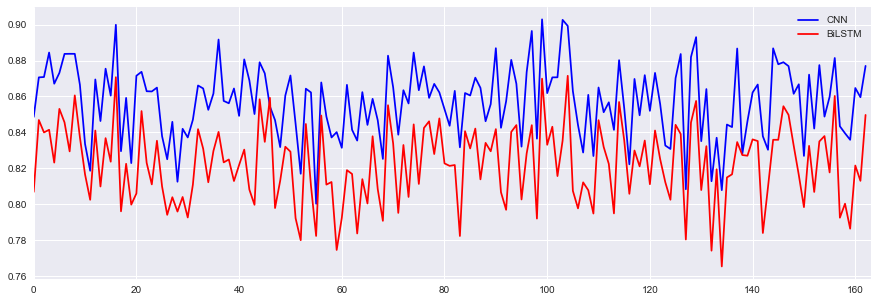

In [57]:
fig, axes = plt.subplots(figsize= (15,5))

sns.lineplot(ax= axes, x= range(len(test_batched_comparison)), y= cnn_loss, color='blue', label= "CNN")
sns.lineplot(ax= axes, x= range(len(test_batched_comparison)), y= bilstm_loss, color='red', label= "Bi-LSTM")
# axes.set_xlim(0,163)

In [62]:
print(f"CNN Accuracy - Mean: {np.mean(cnn_accs)*100:.2f}%, Std: {np.std(cnn_accs)*100:.2f}%")
print(f"Bi-LSTM Accuracy - Mean: {np.mean(bilstm_accs)*100:.2f}%, Std: {np.std(bilstm_accs)*100:.2f}%")

CNN Accuracy - Mean: 85.71%, Std: 2.05%
Bi-LSTM Accuracy - Mean: 82.23%, Std: 2.16%


In [70]:
delta = [cnn_accs[i] - bilstm_accs[i] for i in range(len(test_batched_comparison))]
Delta = np.mean(delta)
Var = np.mean([(delta[i]- Delta)**2 for i in range(len(test_batched_comparison))])
print(f"Test Statistic T = {np.round(Delta / np.sqrt(Var),2)}")
print(f"Corresponding p-value (lowest alpha value) = {0.00673}")

Test Statistic T = 2.72
Corresponding p-value (lowest alpha value) = 0.00673


#### This implied that we can say with 99.98% confidence, the CNN model performs better than the Bi-LSTM model